# Evaluating Shifts in Medicare Spending Across US States
#### Aayush Joshipura, Alisa Posner, Jaeson Pyeon, Vishnu Kasireddy
#### Northeastern University, Boston, MA, USA


In [116]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pylab import *
from sklearn import metrics
import plotly
import plotly.express as px

In [2]:
def state_to_abbrev(df):
    """ converts state name to abbreviation """
    for i in range(len(df.index)):
        state = df.iloc[i]["State"].strip()
        df.at[i,"State"] = us_state_to_abbrev[state]
    df.rename(columns = {"State": "Abbrev"}, inplace = True)

In [9]:
def vis_attribute(df, attribute, target, color, pos1, pos2):
    """ plots subplot representing relationship between attribute and target """
    sns.kdeplot(ax=axes[pos1, pos2], data=df, x=attribute, y=target, fill=True, color=color)
    sns.scatterplot(ax=axes[pos1, pos2], data=df, x=attribute, y=target, color="cornflowerblue")
    axes[pos1, pos2].set_xlabel(attribute.capitalize())
    axes[pos1, pos2].set_ylabel("Medicare Spending")
    axes[pos1, pos2].set_title(attribute.capitalize() + " vs. Medicare Spending")
    axes[pos1, pos2].grid()

In [4]:
def plot_ml(df, attribute, pos1, pos2):
    """ plots testing and training set results between attribute and target """
    X = df[[attribute]]
    y = df[["target"]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    regressor = LinearRegression()
    regressor.fit(X_train,y_train)
    
    # Plotting training set results
    sns.scatterplot(ax=axes[pos1, pos2], x=X_train[attribute].tolist(), y=y_train["target"].tolist(), color="cornflowerblue", s=70)
    sns.lineplot(ax=axes[pos1, pos2], x=X_train[attribute].tolist(), y=list(regressor.predict(X_train).flat), color="blue", linewidth=3)
    
    # Plotting testing set results
    sns.scatterplot(ax=axes[pos1+1, pos2], x=X_test[attribute].tolist(), y=y_test["target"].tolist(), color="darkorange", s=70)
    sns.lineplot(ax=axes[pos1+1, pos2], x=X_train[attribute].tolist(), y=list(regressor.predict(X_train).flat), color="darkred", linewidth=3)

    # Setting labels
    for i in range(2):
        axes[pos1+i, pos2].set_xlabel(attribute.capitalize())
        axes[pos1+i, pos2].set_ylabel("Medicare Spending")
        axes[pos1+i, pos2].grid()
    axes[pos1, pos2].set_title(attribute.capitalize() + " vs. Medicare (Training)")
    axes[pos1+1, pos2].set_title(attribute.capitalize() + " vs. Medicare (Testing)")

In [145]:
state_names = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
us_state_to_abbrev = {"Alabama": "AL","Alaska": "AK","Arizona": "AZ","Arkansas": "AR","California": "CA","Colorado": "CO", "Connecticut": "CT","Delaware": "DE","Florida": "FL","Georgia": "GA","Hawaii": "HI","Idaho": "ID", "Illinois": "IL","Indiana": "IN","Iowa": "IA","Kansas": "KS","Kentucky": "KY","Louisiana": "LA", "Maine": "ME","Maryland": "MD","Massachusetts": "MA","Michigan": "MI","Minnesota": "MN", "Mississippi": "MS","Missouri": "MO","Montana": "MT","Nebraska": "NE","Nevada": "NV", "New Hampshire": "NH","New Jersey": "NJ","New Mexico": "NM","New York": "NY","North Carolina": "NC", "North Dakota": "ND","Ohio": "OH","Oklahoma": "OK","Oregon": "OR","Pennsylvania": "PA", "Rhode Island": "RI","South Carolina": "SC","South Dakota": "SD","Tennessee": "TN","Texas": "TX", "Utah": "UT","Vermont": "VT","Virginia": "VA","Washington": "WA","West Virginia": "WV", "Wisconsin": "WI","Wyoming": "WY"}
years = [2013,2014,2015,2016,2017,2018,2019]
attributes = ["population", "births", "gsp", "health_status", "insurance_cov",
              "mental", "poverty", "deaths"]

# Reading in files
target = pd.read_csv("medicare_spending.csv")
births = pd.read_csv("births.csv")
governors = pd.read_csv("governors.csv")
gsp = pd.read_csv("gsp.csv")
health_status = pd.read_csv("health_status.csv")
insurance_cov = pd.read_csv("insurance_coverage.csv")
mental = pd.read_csv("mental_health.csv")
poverty = pd.read_csv("poverty_level.csv")
deaths = pd.read_csv("deaths.csv")

# Cleaning up births df
births.drop(["Footnotes"], axis=1, inplace=True)
births.columns = ["State",2013,2014,2015,2016,2017,2018,2019]
births = births[births['State'].isin(state_names)]

# Cleaning up governors df - represents political party of each state
governors = governors[governors['state'].isin(state_names)]
governors.dropna(axis=0, inplace=True)
governors.drop(["year"], axis=1, inplace=True)
governors.columns = [col.capitalize() for col in governors.columns]
governors.reset_index(inplace=True)
governors.drop("index", axis=1, inplace=True)
governors["Start"] = 0
governors["End"] = 0
for i in range(len(governors.index)):
    start = int(governors.iloc[i]["Time_in_office"].split("-")[0])
    end = int(governors.iloc[i]["Time_in_office"].split("-")[1])
    governors.at[i,"Start"] = start
    governors.at[i,"End"] = end
governors = governors[governors["End"] >= 2013]
governors = governors[(governors["Party"] == "Republican") | (governors["Party"] == "Democrat")]
governors.drop(["Governor", "Time_in_office"], axis=1, inplace=True)
governors.reset_index(inplace=True)
governors.drop("index", axis=1, inplace=True)
state_party_dct = {}
for state in us_state_to_abbrev.values():
    state_party_dct[state] = {year:{"Rep":0, "Dem":0} for year in years}
for i in range(len(governors.index)):
    abbrev = us_state_to_abbrev[governors.iloc[i]["State"]]
    party = governors.iloc[i]["Party"]
    start = governors.iloc[i]["Start"]
    end = governors.iloc[i]["End"]    
    for year in years:
        if year >= start and year <= end:
            if party == "Republican":
                state_party_dct[abbrev][year]["Rep"] += 1
            elif party == "Democrat":
                state_party_dct[abbrev][year]["Dem"] += 1
for state in state_party_dct:
    for year in years:
        reps = state_party_dct[state][year]["Rep"]
        dems = state_party_dct[state][year]["Dem"]
        if reps > dems:
            state_party_dct[state][year] = "Rep"
        elif dems > reps:
            state_party_dct[state][year] = "Dem"
        elif reps == dems:
            state_party_dct[state][year] = "Equal"
for state in state_party_dct:
    rep_years = list(state_party_dct[state].values()).count("Rep")
    dem_years = list(state_party_dct[state].values()).count("Dem")
    if rep_years > dem_years:
        status = "Rep"
    elif dem_years > rep_years:
        status = "Dem"
    elif dem_years == rep_years:
        status = "Equal"
    state_party_dct[state] = status
state_party = pd.DataFrame(data=state_party_dct.values(), index=state_party_dct.keys(), columns=["Party"])

# Cleaning up gross state product (gsp) df
gsp.columns = ["State", 2011,2012,2013,2014,2015,2016,2017,2018,2019]
gsp.drop([2011,2012], axis=1, inplace=True)
gsp = gsp[gsp['State'].isin(state_names)]

# Cleaning up health status df - represents the proportion of the population that feels poor
for column in health_status.columns[1:]:
    if column.split("_")[-1] != "Poor":
        health_status.drop(column, axis=1, inplace=True)
health_status.columns = ["State",2013,2014,2015,2016,2017,2018,2019,2020]
health_status.drop([2020], axis=1, inplace=True)
health_status = health_status[health_status['State'].isin(state_names)]

# Cleaning up insurance coverage df - represents the proportion of the population that is uninsured
for column in insurance_cov.columns[1:]:
    if column.split("_")[0] not in str(years) or column.split("_")[-1] != "Uninsured":
        insurance_cov.drop(column, axis=1, inplace=True)
insurance_cov.columns = ["State",2013,2014,2015,2016,2017,2018,2019]
insurance_cov = insurance_cov[insurance_cov['State'].isin(state_names)]

# Cleaning up mental df - represents the proportion of the population that feels bad mentally 14+ days out of the month
for column in mental.columns[1:]: 
    if column.split("_")[-1] != "14+ Days":
        mental.drop(column, axis=1, inplace=True)
mental.columns = ["State",2013,2014,2015,2016,2017,2018,2019,2020]
mental.drop([2020], axis=1, inplace=True)
mental = mental[mental['State'].isin(state_names)]

# Cleaning up poverty df - represents the proportion of the population that makes less than 100% of the Federal Poverty Level
for column in poverty.columns[1:]:
    if column.split("_")[-1] != "Under 100%":
        poverty.drop(column, axis=1, inplace=True)
poverty.columns = ["State",2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
poverty.drop([2008,2009,2010,2011,2012], axis=1, inplace=True)
poverty = poverty[poverty['State'].isin(state_names)]

# Cleaning up target df
target.columns = ["State",2013,2014,2015,2016,2017,2018,2019]
target = target[target['State'].isin(state_names)]
target.reset_index(inplace=True)
target.drop("index", axis=1, inplace=True)

# Cleaning up deaths df
deaths = deaths[deaths["Notes"] != "Total"]
population = deaths[["State", "Year", "Population"]]
deaths.drop(["Notes", "Population"], axis=1, inplace=True)
deaths = deaths.pivot(index="State", columns='Year')
deaths.reset_index(inplace=True)
deaths.columns = ["State",2013,2014,2015,2016,2017,2018,2019]

# Cleaning up population df
population = population.pivot(index="State", columns='Year')
population.reset_index(inplace=True)
population.columns = ["State",2013,2014,2015,2016,2017,2018,2019]
population["2013to2019"] = (population[2019]-population[2013])*100/population[2013]

# Calculating per capita by dividing target by population
target_capita = target[["State"]]
for i in range(2013,2020):
    target_capita[i] = target[i]/population[i]
    
# Totaling medicare spending
total_medicare = pd.DataFrame(target[years].sum(), columns=["Total"])

# Totaling population
total_population = pd.DataFrame(population[years].sum(), columns=["Total"])

# Finding US medicare per capita
us_mpc = pd.DataFrame(total_medicare["Total"]/total_population["Total"])

# Calculating percent changes in total medicare
t_pct = target[years].pct_change(axis="columns")
t_pct = t_pct*100
t_pct[2013] = target_capita["State"]
t_pct.columns = ["State"] + years[1:]
t_pct["2013to2019"] = (target[2019]-target[2013])*100/target[2013]

# Calculating percent changes in medicare per capita
tc_pct = target_capita[years].pct_change(axis="columns")
tc_pct = tc_pct*100
tc_pct[2013] = target_capita["State"]
tc_pct.columns = ["State"] + years[1:]
tc_pct["2013to2019"] = (target_capita[2019]-target_capita[2013])*100/target_capita[2013]

# All dataframes
dfs = [target, population, births, gsp, health_status, insurance_cov, mental, poverty, deaths,
      target_capita, t_pct, tc_pct]

# Reseting indexes and converting state names to abbreviations
for df in dfs:
    df.reset_index(inplace=True)
    df.drop(["index"], axis=1, inplace=True)
    state_to_abbrev(df)
    df.set_index("Abbrev", inplace=True)

# Combining dataframe for all attributes for total medicare spending
combined = target.copy()
for year in years:
    for i in range(len(attributes)):
        combined[str(year)+attributes[i]] = dfs[1:9][i][year]
combined.rename(columns={y:str(y)+"target" for y in years}, inplace=True)
# Rearranging columns
sorted_cols = []
for year in years:
    for col in combined.columns:
        if str(year) in col:
            sorted_cols.append(col)
combined = combined[sorted_cols]
combined.columns = pd.MultiIndex.from_product([years, ["target"]+attributes], names=['Year', 'Attribute'])

# Combining dataframe for all attributes for medicare spending per capita
combined_capita = target_capita.copy()
for year in years:
    for i in range(len(attributes)):
        combined_capita[str(year)+attributes[i]] = dfs[1:9][i][year]
combined_capita.rename(columns={y:str(y)+"target" for y in years}, inplace=True)
# Rearranging columns
sorted_cols = []
for year in years:
    for col in combined_capita.columns:
        if str(year) in col:
            sorted_cols.append(col)
combined_capita = combined_capita[sorted_cols]
combined_capita.columns = pd.MultiIndex.from_product([years, ["target"]+attributes], names=['Year', 'Attribute'])

# Disregarding years and creating one long dataframe for total medicare spending
long = combined.reset_index()[2013]
for year in years[1:]:
    long = long.append(combined.reset_index()[year], ignore_index=True)
long.dropna(axis=0, inplace=True)
long.reset_index(inplace=True)
long.drop("index", axis=1, inplace=True)
long.index.rename("Index", inplace=True)

# Disregarding years and creating one long dataframe for medicare spending per capita
long_capita = combined_capita.reset_index()[2013]
for year in years[1:]:
    long_capita = long_capita.append(combined_capita.reset_index()[year], ignore_index=True)
long_capita.dropna(axis=0, inplace=True)
long_capita.reset_index(inplace=True)
long_capita.drop("index", axis=1, inplace=True)
long_capita.index.rename("Index", inplace=True)

<ipython-input-145-ba38772c934a>:137: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



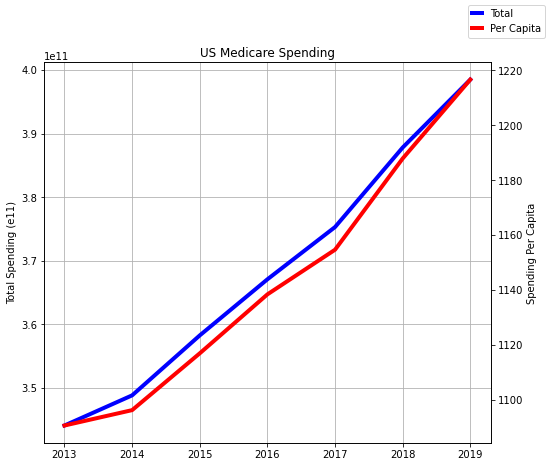

In [156]:
# Ploting total medicare spending and per capita over time
plt.figure(figsize=(8, 7))
ax = sns.lineplot(x=years, y=list(target[years].sum()), linewidth=4, color="blue", label="Total", legend=False)
plt.ylabel("Total Spending (e11)")
plt.grid()
ax2 = ax.twinx()
sns.lineplot(x=years, y=us_mpc["Total"], linewidth=4, color="red", label="Per Capita", legend=False)
plt.title("US Medicare Spending")
plt.xlabel("Year")
plt.ylabel("Spending Per Capita")
ax.figure.legend()

Text(0.5, 0.93, 'Attributes vs. Total Medicare Spending')

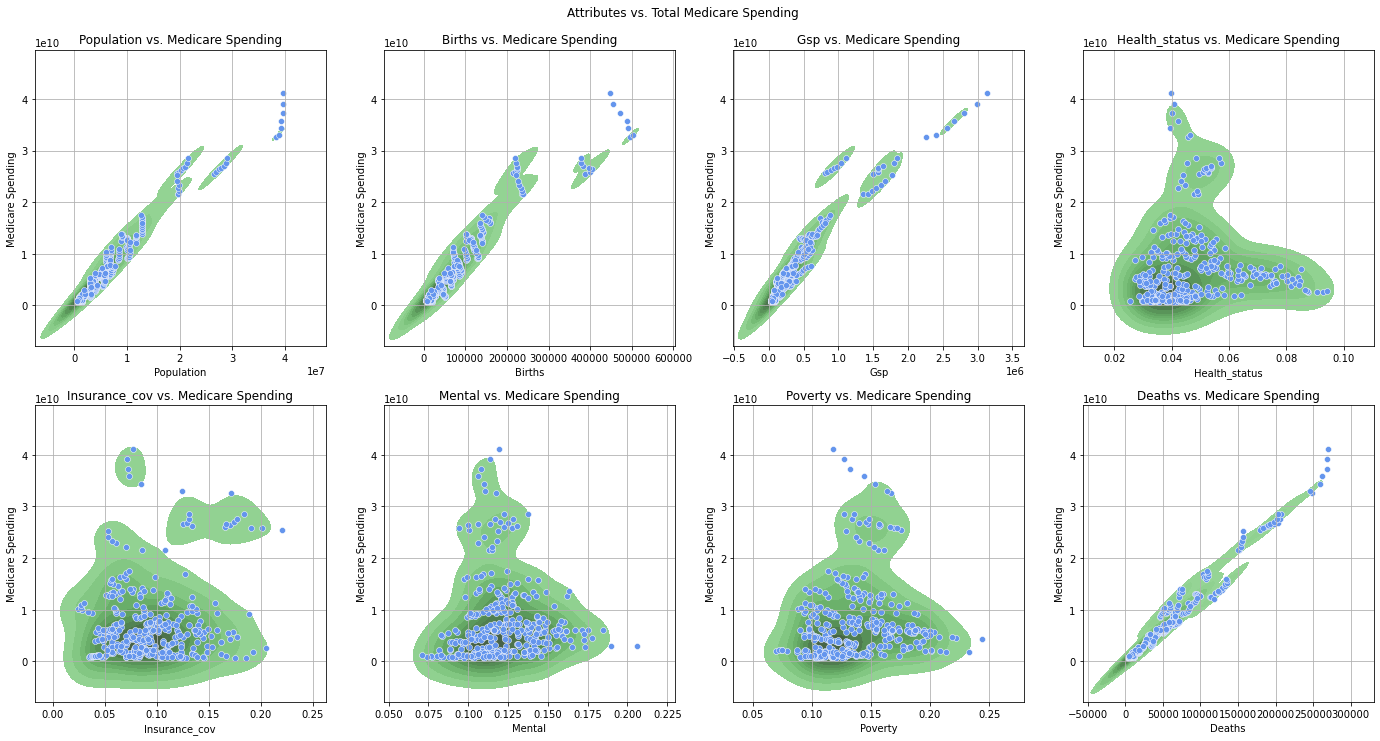

In [147]:
# Plotting kde and scatter plots with attributes against medicare spending
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
pos1s=[0,0,0,0,1,1,1,1]
pos2s=[0,1,2,3,0,1,2,3]
for i in range(len(attributes)):
    vis_attribute(long, attributes[i], "target", "lightgreen", pos1s[i], pos2s[i])
plt.suptitle("Attributes vs. Total Medicare Spending", y=0.93)

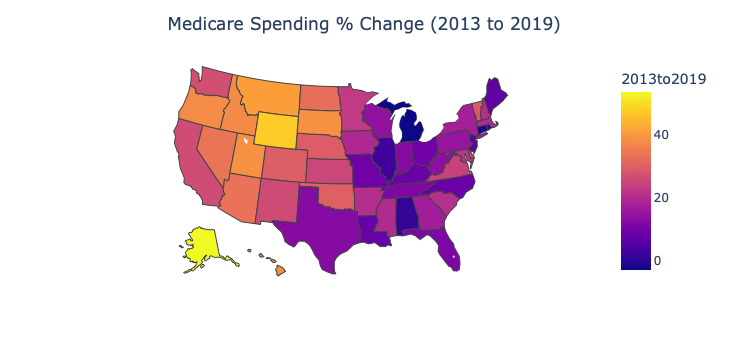

In [148]:
# Plotting medicare spending percent change from 2013 to 2019 for entire US
fig = px.choropleth(t_pct,  # Input Pandas DataFrame
                    locations=target.index,  # DataFrame column with locations
                    color="2013to2019",  # DataFrame column with color values
                    #hover_name="Abbrev", # DataFrame column hover info
                    scope="usa",
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(title={'text':"Medicare Spending % Change (2013 to 2019)",
                         'x':0.5, 'xanchor':'center'})
fig.show()

Text(0.5, 1.0, 'Population % Change vs. Medicare % Change (2013 to 2019)')

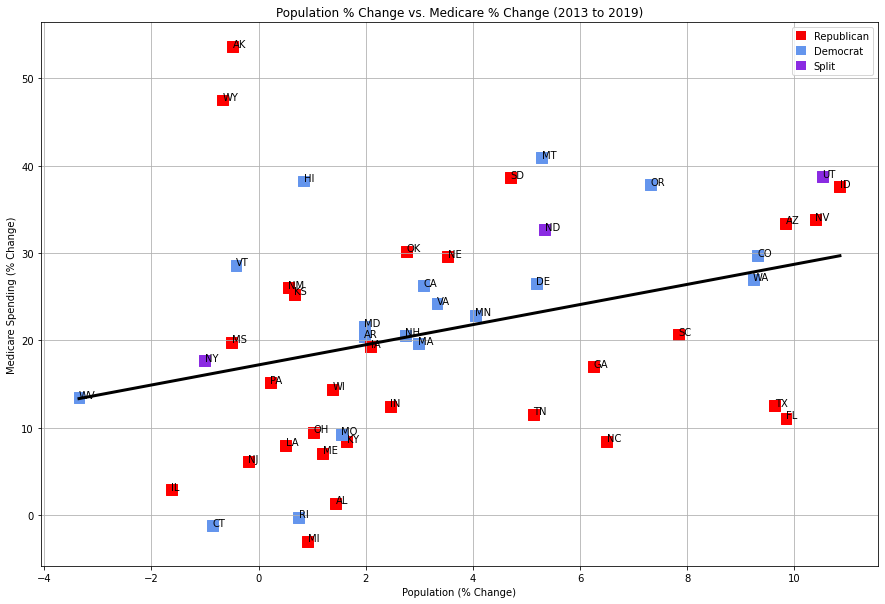

In [154]:
# Creating dataframe for 2013 to 2019 state medicare % change, population % change,
# and party affiliation
pop_target = population[["2013to2019"]].copy()
pop_target.rename(columns={"2013to2019":"Population Change"}, inplace=True)
pop_target["Medicare Change"] = t_pct["2013to2019"]
pop_target["Color"] = "Black"

# Color-coding based on party
for state in state_party.index:
    party = state_party.loc[state]["Party"]
    if party == "Rep":
        color = "red"
    elif party == "Dem":
        color = "cornflowerblue"
    elif party == "Equal":
        color = "blueviolet"
    pop_target.at[state,"Color"] = color

# Plotting 
x=pop_target["Population Change"]
y=pop_target["Medicare Change"]
color=pop_target["Color"]
label=pop_target.index.tolist()
plt.figure(figsize=(15, 10))
plt.scatter(x=x, y=y, color=color, s=120, marker="s")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), linewidth=3, color="black")
for i in range(len(x)):
    plt.annotate(label[i], (x[i], y[i]))

# Custom legend
rect1 = patches.Rectangle((0,0),1,1,facecolor='#F40103')
rect2 = patches.Rectangle((0,0),1,1,facecolor='#6495ED')
rect3 = patches.Rectangle((0,0),1,1,facecolor='#8A2BE2')
plt.legend((rect1, rect2, rect3), ('Republican', 'Democrat', 'Split'))

plt.grid()
plt.xlabel("Population (% Change)")
plt.ylabel("Medicare Spending (% Change)")
plt.title("Population % Change vs. Medicare % Change (2013 to 2019)")